# 부산광역시의 지하철역 수는 상가수, 인구수와 비례할까?
* 공공데이터 
    * https://www.data.go.kr/data/15012005/fileData.do
    * https://www.data.go.kr/data/3076607/fileData.do
    * https://www.data.go.kr/data/15041101/fileData.do

## 정의
* 부산광역시의 1, 2, 3, 4호선 지하철이 지나가는 역을 부산광역시 지하철역이라 함. (경전철, 동해선 제외)
* 지하철역이 속하는 구군은 지하철역 주소를 따름.


(참고) 지하철역 주소 데이터 기준 날짜는 19/11/22 이고 나머지 데이터는 19/12/01 이지만 부산교통공사 홈페이지에서 찾아본 결과 19/11/22 ~ 19/12/01 기간에 신설한 지하철역이 없으므로 데이터 기준 날짜 차이는 무시함. 

## 설계

### 판다스 패키지, 시각화, 한글폰트, 해상도 설정

In [1]:
# 1. 라이브러리 호출
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# 2. 시각화 설정
import folium
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# 3. 한글폰트를 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 4. 해상도
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

### 데이터 전처리

In [2]:
def store_preprocessing(path):
    raw_store = pd.read_csv(path, sep = '|')
    df_store = raw_store[['시도명', '시군구명']]
    df_store = df_store[df_store['시도명'] == '부산광역시']
    df_store = df_store.groupby('시군구명').count()
    df_store.columns = ['상가수']
    df_store = df_store.sort_values(by='상가수', ascending=False)
    
    return df_store

store_path = f'상가업소정보_201912_01.csv'
num_of_store = store_preprocessing(store_path)

In [3]:
def human_preprocessing(path):
    raw_human = pd.read_excel(human_path)
    df_human = raw_human[raw_human['제공연도'] == '2019-12']
    df_human = df_human.drop(85)
    df_human['구군'] = df_human['구군'].dropna().apply(lambda x : x.split(' ')[1])
    df_human.index = df_human['구군']
    df_human = df_human[['총인구수']]
    df_human = df_human.sort_values(by='총인구수', ascending=False)
    
    return df_human

human_path = f'부산시 주민등록인구 통계정보 서비스.xlsx'
num_of_human = human_preprocessing(human_path)

In [4]:
def metro_preprocessing(path):
    raw_metro = pd.read_csv(metro_path, sep = ',' ,encoding = 'CP949')
    raw_metro['소속구군'] = raw_metro['지번주소'].dropna().apply(lambda x : x.split(' ')[1])
    df_metro = raw_metro[['역명','소속구군']]
    df_metro = df_metro.groupby('소속구군').count()
    df_metro.columns = ['지하철역 수']
    df_metro.loc['영도구'] = 0
    df_metro = df_metro.sort_values(by='지하철역 수', ascending=False)
    
    return df_metro

metro_path = f'한국철도시설공단_부산_지하철_주소데이터_20191122.csv'
num_of_metro = metro_preprocessing(metro_path)

* 부산광역시 구군별 위도, 경도 데이터 (site : http://www.mapnall.com )

In [5]:
pusan_lat_long = [
    ['북구', 35.229638, 129.024199],
    ['사하구', 35.085556, 128.987222],
    ['동래구', 35.206245, 129.079233],
    ['부산진구', 35.165376, 129.043135],
    ['해운대구', 35.181652, 129.163335],
    ['금정구', 35.258611, 129.090000],
    ['연제구', 35.182443, 129.082985],
    ['사상구', 35.159081, 128.987088],
    ['수영구', 35.153230, 129.120604],
    ['남구', 35.115504, 129.099916],
    ['동구', 35.126727, 129.046789],
    ['중구', 35.105033, 129.037272],
    ['강서구', 35.108830, 128.874739],
    ['서구', 35.087947, 129.018921],
    ['기장군', 35.289059, 129.215836],
    ['영도구', 35.069944, 129.068585]]

### 데이터 가공

In [6]:
merge_store_human = pd.merge(num_of_store, num_of_human, left_on = num_of_store.index, right_on = num_of_human.index)
store_human_metro = pd.merge(merge_store_human, num_of_metro, left_on = 'key_0', right_on = num_of_metro.index)
store_human_metro = store_human_metro.sort_values(by='지하철역 수', ascending=False)
store_human_metro.columns = ['구군', '상가수', '총인구수', '지하철역 수']
store_human_metro = store_human_metro.reset_index()

for i in store_human_metro.index:
    store_human_metro.loc[store_human_metro.index[i], '위도'] = pusan_lat_long[i][1]
    store_human_metro.loc[store_human_metro.index[i], '경도'] = pusan_lat_long[i][2]

store_human_metro.index = store_human_metro['구군']
store_human_metro = store_human_metro[['상가수', '총인구수', '지하철역 수','위도','경도']]

## 시각화

* 인구 수에 따른 지하철역 수

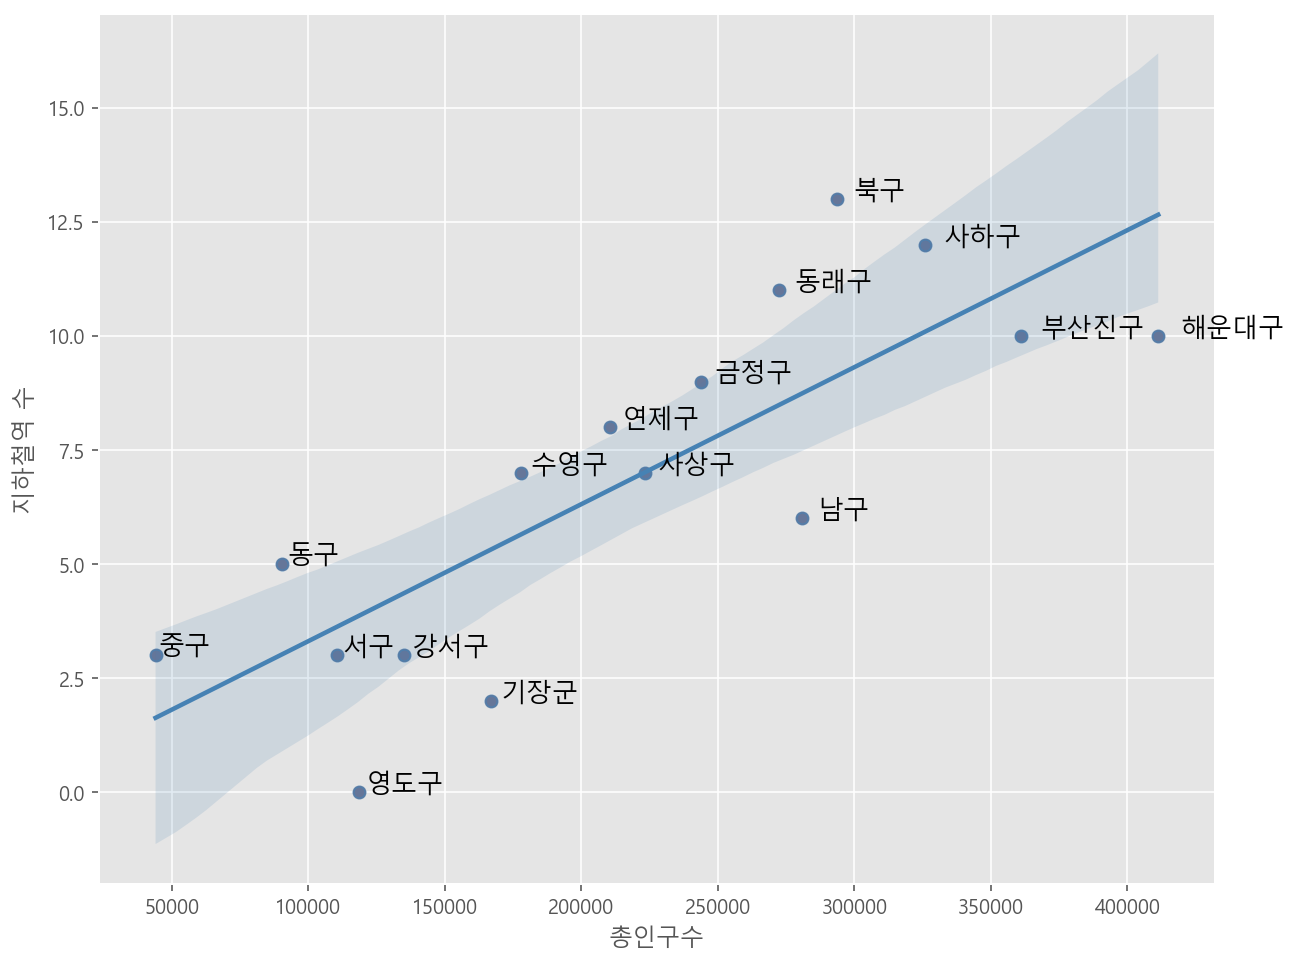

In [7]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter(store_human_metro['총인구수'], store_human_metro['지하철역 수'])
sns.regplot(store_human_metro['총인구수'], store_human_metro['지하철역 수'], scatter=True, color='steelblue')

for name in store_human_metro.index:
    plt.text(store_human_metro['총인구수'][name]*1.02, store_human_metro['지하철역 수'][name], name, fontsize=13)
plt.xlabel('총인구수')
plt.ylabel('지하철역 수')
plt.show();

* 상가 수에 따른 지하철역 수

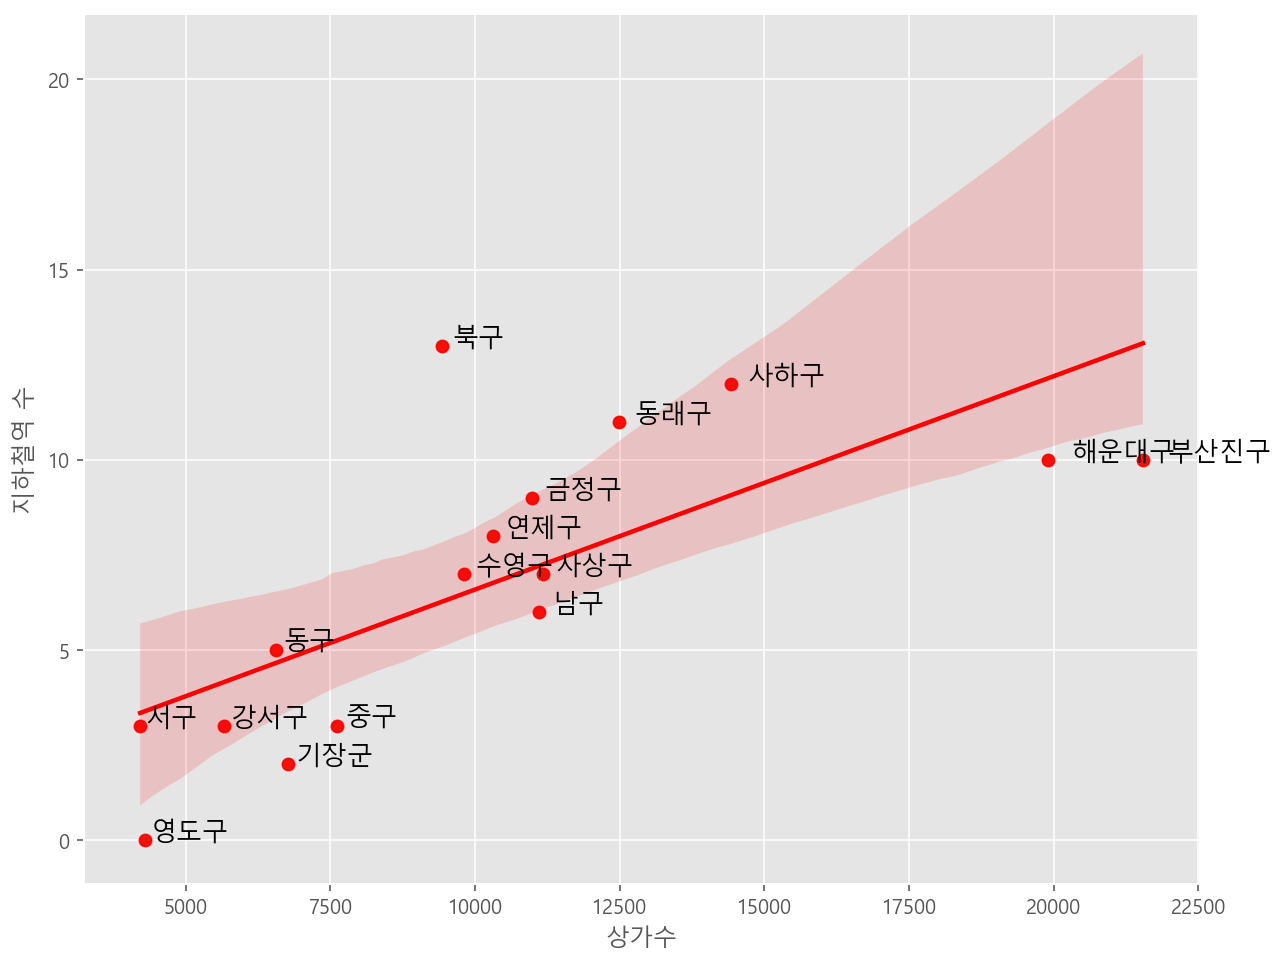

In [8]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter(store_human_metro['상가수'], store_human_metro['지하철역 수'])
sns.regplot(store_human_metro['상가수'], store_human_metro['지하철역 수'], scatter=True, color='red')

for name in store_human_metro.index:
    plt.text(store_human_metro['상가수'][name]*1.02, store_human_metro['지하철역 수'][name], name, fontsize=13)
plt.xlabel('상가수')
plt.ylabel('지하철역 수')
plt.show();

# 지도 시각화

In [9]:
geo_path = f'pusan_municipalities_geo_simple.json'

m = folium.Map(location = [35.137922, 129.055628],zoom_start = 11,tiles='Stamen Toner')
geo_json = json.load(open(geo_path, encoding="utf-8"))
folium.Choropleth(
    geo_data = geo_json,
    name='지하철역 수',
    data = store_human_metro,
    columns=[store_human_metro.index, '지하철역 수'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity =0.7,
    line_opacity=0.2,
    legend_name='행정구역의 지하철역 수'
).add_to(m)

In [10]:
for i in store_human_metro.index:
    sub_lat = store_human_metro.loc[i,'위도']
    sub_long = store_human_metro.loc[i,'경도']
    
    store_radius = store_human_metro.loc[i,'상가수']/1000
    human_radius = store_human_metro.loc[i,'총인구수']/20000
    store_title = f"{i} 상가수 : {store_human_metro.loc[i,'상가수']}개"
    human_title = f"{i} 인구수 : {store_human_metro.loc[i,'총인구수']}명"
            
    folium.CircleMarker(location=[sub_lat,sub_long+0.005],
                        radius = store_radius,
                        color='yellow',
                        tooltip = store_title,
                        fill=True).add_to(m)
    
    folium.CircleMarker(location=[sub_lat,sub_long-0.005],
                        radius = human_radius,
                        color='blue',
                        tooltip = human_title,
                        fill=True).add_to(m)

In [11]:
m

In [12]:
m.save('project_map.html')